Generating data on cuda...


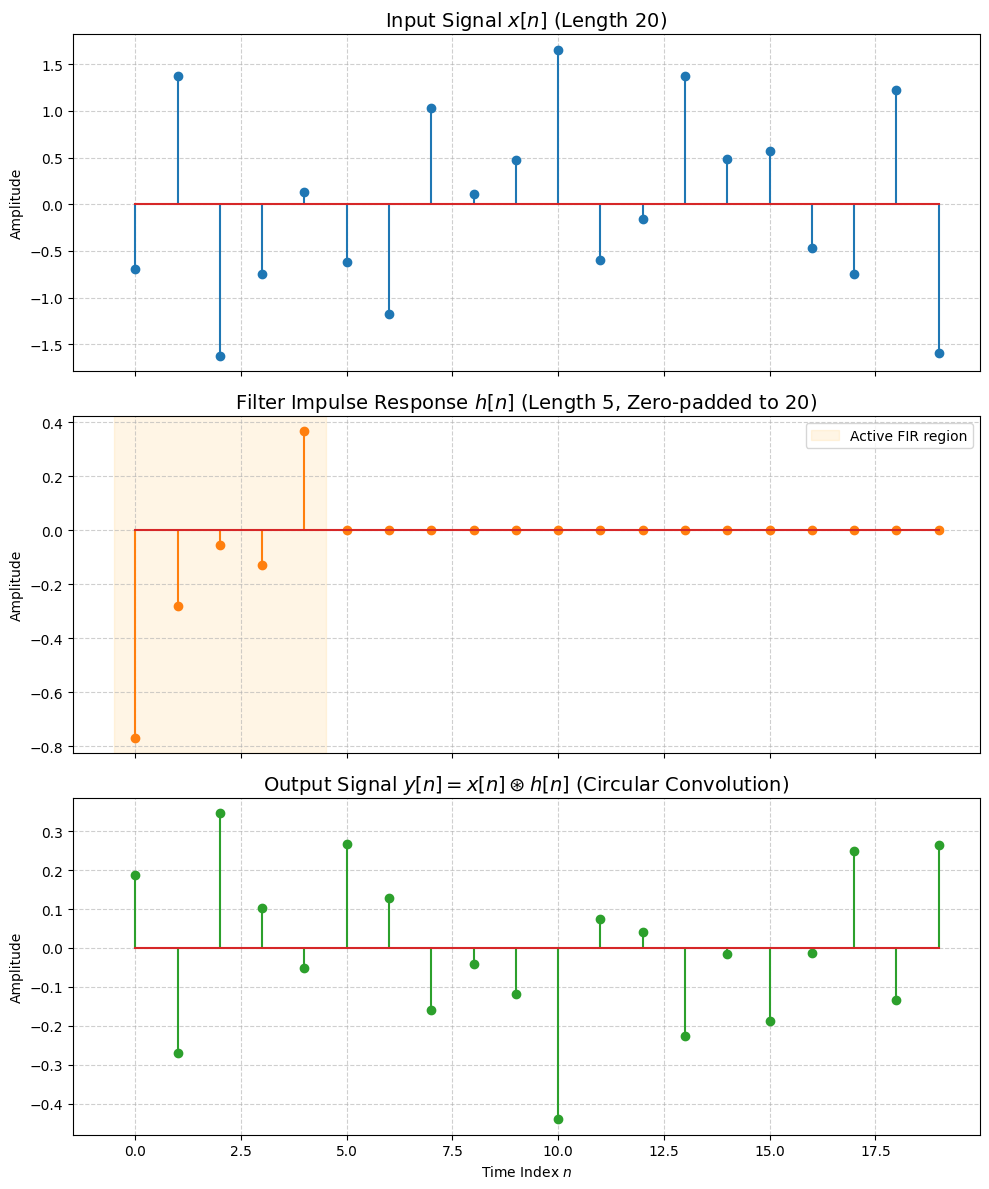

In [10]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from samplers import SignalSampler
from tasks import SignalConvolutionTask

def plot_signal_convolution():
    # --- Configuration ---
    # We use CPU to ensure it runs easily locally, but you can change to "cuda" if available.
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    
    # Parameters
    BATCH_SIZE = 1      # We only need 1 batch to visualize
    N_POINTS = 1        # Number of input signals (x) to generate per batch
    P = 20           # The period/length of the signal (n_dims for time domain)
    FIR_LEN = 5        # The length of the impulse response h
    DOMAIN = "time"     # Working in time domain

    print(f"Generating data on {DEVICE}...")

    # --- 1. Generate Input Signals (x) ---
    # Initialize the sampler
    sampler = SignalSampler(
        n_dims=P, 
        p=P, 
        domain=DOMAIN, 
        device=DEVICE
    )
    
    # Sample x (Shape: [Batch, N_Points, P])
    xs = sampler.sample_xs(n_points=N_POINTS, b_size=BATCH_SIZE)

    # --- 2. Initialize Task & Generate Filter (h) ---
    # The task initializes the random filter h internally upon creation
    task = SignalConvolutionTask(
        n_dims=P, 
        batch_size=BATCH_SIZE, 
        p=P, 
        fir_len=FIR_LEN, 
        domain=DOMAIN, 
        device=DEVICE
    )

    # --- 3. Compute Output (y) ---
    # Calculate circular convolution y = x * h
    ys = task.evaluate(xs)

    # --- 4. Prepare Data for Plotting ---
    # We grab the first item in the batch and the first sequence point
    b_idx = 0
    t_idx = 0

    # Convert to numpy for plotting
    x_data = xs[b_idx, t_idx, :].cpu().numpy()
    y_data = ys[b_idx, t_idx, :].cpu().numpy()
    
    # Get h data. Note: h is length FIR_LEN, but conceptually acts over length P (zero-padded)
    h_short = task.h[b_idx, :].cpu().numpy()
    h_data = np.zeros(P)
    h_data[:FIR_LEN] = h_short

    # --- 5. Plotting ---
    fig, axs = plt.subplots(3, 1, figsize=(10, 12), sharex=True)
    
    # Common styles

    # Plot x (Input)
    axs[0].stem(range(P), x_data)
    axs[0].set_title(f"Input Signal $x[n]$ (Length {P})", fontsize=14)
    axs[0].set_ylabel("Amplitude")
    axs[0].grid(True, linestyle='--', alpha=0.6)

    # Plot h (Filter)
    axs[1].stem(range(P), h_data, linefmt='C1-', markerfmt='C1o')
    axs[1].set_title(f"Filter Impulse Response $h[n]$ (Length {FIR_LEN}, Zero-padded to {P})", fontsize=14)
    axs[1].set_ylabel("Amplitude")
    axs[1].grid(True, linestyle='--', alpha=0.6)
    # Highlight the active FIR region
    axs[1].axvspan(-0.5, FIR_LEN-0.5, color='orange', alpha=0.1, label="Active FIR region")
    axs[1].legend()

    # Plot y (Output)
    axs[2].stem(range(P), y_data, linefmt='C2-', markerfmt='C2o')
    axs[2].set_title(r"Output Signal $y[n] = x[n] \circledast h[n]$ (Circular Convolution)", fontsize=14)
    axs[2].set_xlabel("Time Index $n$")
    axs[2].set_ylabel("Amplitude")
    axs[2].grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    plot_signal_convolution()